# EASYMORE Basin Subset
EASYMORE: EArth SYstem MOdeling REmapper is a collection of functions that allows extraction of the data from a NetCDF file for a given shapefile such as a basin, catchment, points or lines. It can map gridded data or model output to any given shapefile and provide area average for a target variable.
https://github.com/ShervanGharari/EASYMORE

## Subbasin Selection
This is an optional script to extract a smaller domain of interest from within a larger domain of discretized subbasins in a shapefile format.

### Load Modules

In [1]:
from easymore.easymore import easymore
import geopandas as gpd
import numpy as np
from pathlib import Path
from shutil import copyfile
from datetime import datetime

### Control File Handling
The purpose of the control file is to provide all inputs to the scripts in the vector-based workflow to eliminate the need to alter the workflow scripts themselves. The following cells will retrieve settings from 'control_active.txt' and provide them as inputs to this script.

##### Access to the control file folder

In [2]:
controlFolder = Path('../0_control_files')

##### Store the name of the 'active' file in a variable

In [3]:
controlFile = 'control_active.txt'

##### Function to extract a given setting from the control file

In [4]:
def read_from_control( file, setting ):
     
    # Open 'control_active.txt' and ...
    with open(file) as contents:
        for line in contents:
             
            # ... find the line with the requested setting
            if setting in line and not line.startswith('#'):
                break
     
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
        
    # Return this value   
    return substring

##### Function to specify a default path

In [5]:
def make_default_path(suffix):
     
    # Get the root path
    rootPath = Path( read_from_control(controlFolder/controlFile,'root_path') )
     
    # Specify the forcing path
    #defaultPath = rootPath / domainFolder / suffix
    defaultPath = rootPath / suffix 
    return defaultPath

##### Get the domain folder

In [6]:
domain_name = read_from_control(controlFolder/controlFile,'domain_name')
domainFolder = 'domain_' + domain_name

##### Assigning input files

In [7]:
# Assign the parent basin
input_basin_path = read_from_control(controlFolder/controlFile,'input_basin_path')
input_basin_name = read_from_control(controlFolder/controlFile,'input_basin_name')
# Specify default path if needed
if input_basin_path == 'default':
    input_basin_path = make_default_path('shapefiles/catchment/') # outputs a Path()
else:
    input_basin_path = Path(input_basin_path) # make sure a user-specified path is a Path()

In [8]:
# Assign the parent river network
input_river_path = read_from_control(controlFolder/controlFile,'input_river_path')
input_river_name = read_from_control(controlFolder/controlFile,'input_river_name')
if input_river_path == 'default':
    input_river_path = make_default_path('shapefiles/river_network/') # outputs a Path()
else:
    input_river_path = Path(input_river_path) # make sure a user-specified path is a Path()

In [9]:
# Assign the output directories
outdir_basin = read_from_control(controlFolder/controlFile,'subset_basin_outdir')
outdir_river = read_from_control(controlFolder/controlFile,'subset_river_outdir')
if outdir_basin == 'default':
    outdir_basin = make_default_path('shapefiles/catchment/') # outputs a Path()
else:
    outdir_basin = Path(outdir_basin) # make sure a user-specified path is a Path() 
if outdir_river == 'default':
    outdir_river = make_default_path('shapefiles/river_network/') # outputs a Path()
else:
    outdir_river = Path(outdir_river) # make sure a user-specified path is a Path()

##### Get additional settings

In [10]:
hruid = read_from_control(controlFolder/controlFile,'river_basin_shp_rm_hruid')
segid = read_from_control(controlFolder/controlFile,'river_network_shp_segid')
downid = read_from_control(controlFolder/controlFile,'river_network_shp_downsegid')

### Starting EASYMORE

##### Initializing easymore object

In [11]:
esmr = easymore()

EASYMORE version 0.0.4 is initiated.


##### Load the files and calculating the downstream of each segment

In [12]:
riv  = gpd.read_file(input_river_path/input_river_name)
cat    = gpd.read_file(input_basin_path/input_basin_name)

# get all the upstream
seg_IDs  = np.array(riv[segid])
down_IDs = np.array(riv[downid])
NTOPO    = esmr.get_all_downstream (seg_IDs,down_IDs)

# Identify target segment ID
esmr.case_name = read_from_control(controlFolder/controlFile,'case_name') #e.g. 05NG001
target_segment = int(read_from_control(controlFolder/controlFile,'target_segment')) # e.g. 78011863

up_subbasins = esmr.get_all_upstream(target_segment,NTOPO) # segment ID


DriverError: '\mnt\e\GWF_data\shapefiles\riv_pfaf_7\riv_pfaf_71_MERIT_Hydro_v07_Basins_v01_bugfix1.shp' does not exist in the file system, and is not recognized as a supported dataset name.

##### Subset

In [ ]:
cat_up = cat.loc[cat[hruid].isin(up_subbasins)]
riv_up = riv.loc[riv[segid].isin(up_subbasins)]

##### Set CRS to EPSG:4326

In [ ]:
cat_up = cat_up.set_crs(4326)
riv_up = riv_up.set_crs(4326)

##### Plot

<AxesSubplot:>

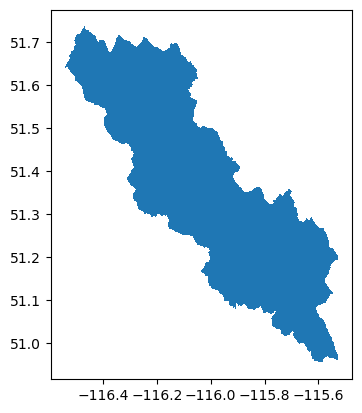

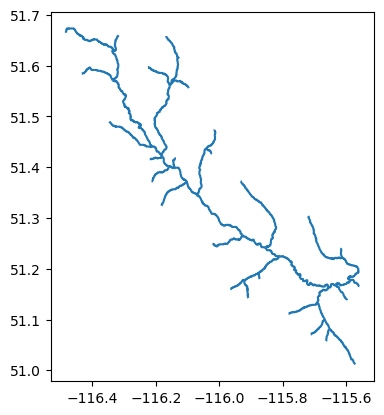

In [ ]:
cat_up.plot()
riv_up.plot()

##### Save files

In [ ]:
cat_up.to_file(str(outdir_basin)+'/'+esmr.case_name+'_cat.shp')
riv_up.to_file(str(outdir_river)+'/'+esmr.case_name+'_riv.shp')

c:\Users\5600x\anaconda3\envs\easymore\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
c:\Users\5600x\anaconda3\envs\easymore\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Code provenance
Generates a basic log file in the domain folder and copies the control file and itself there.


In [ ]:
# Set the log path and file name
logPath = outdir_basin
log_suffix = '_basin_subset.txt'
 
# Create a log folder
logFolder = '_workflow_log'
Path( logPath / logFolder ).mkdir(parents=True, exist_ok=True)
 
# Copy this script
thisFile = 'easymore_basinsubset.ipynb'
copyfile(thisFile, logPath / logFolder / thisFile);
 
# Get current date and time
now = datetime.now()
 
# Create a log file
logFile = now.strftime('%Y%m%d') + log_suffix
with open( logPath / logFolder / logFile, 'w') as file:
     
    lines = ['Log generated by ' + thisFile + ' on ' + now.strftime('%Y/%m/%d %H:%M:%S') + '\n',
             'Generated basin subset .shp files from {} and {}.'.format(input_basin_name,input_river_name)]
    for txt in lines:
        file.write(txt)